In [12]:
import numpy as np
import matplotlib.pyplot as plt

class Learner:
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.t = 0
        self.rewards_per_arm =  x = [[] for i in range(n_arms)] 
        self.collected_rewards = np.array([]) 

    def update_observations(self, pulled_arm, reward):
    # once the reward is returned by the environment
        self.rewards_per_arm[pulled_arm].append(reward)
        self.collected_rewards = np.append(self.collected_rewards,reward) 

class UCB(Learner):
    def __init__(self, n_arms):
        super().__init__(n_arms)
        self.empirical_means = np.zeros(n_arms) + 0.5 #np.array([0.75, 0.5, 0.25, 0.1])
        self.confidence = np.array([np.inf]*n_arms)
    
    def pull_arm(self):
        upper_conf = self.empirical_means + self.confidence
        return np.random.choice(np.where(upper_conf == upper_conf.max())[0])

    def update(self, pull_arm, reward):
        self.t += 1
        self.empirical_means[pull_arm] =(self.empirical_means[pull_arm]*(self.t-1) + reward)/self.t
        for a in range(self.n_arms):
            n_samples = len(self.rewards_per_arm[a])
            self.confidence[a] =(2*np.log(self.t)/n_samples)**0.5 if n_samples > 0 else np.inf
        self.update_observations(pull_arm, reward)

class UserClass:
  def __init__(self,number_of_user, alfas, num_products_bought, p_matrix ) :
    # self.conversion_rate_matrix = np.random.uniform(0.0,1.0,(5,4))      #randomly generates the conversion rates for every price
    self.conversion_rate_matrix = np.array([[0.04, 0.01, 0.01, 0.81],
       [0.19, 0.07, 0.99, 0.3],
       [0.02, 0.10, 0.89, 0.02],
       [0.38 , 0.57, 0.01, 0.41],
       [0.32 , 0.92, 0.47 , 0.30]])
    self.number_of_user = number_of_user
    self.alfas = alfas
    self.num_products_bought = num_products_bought
    self.p_matrix = p_matrix
  
class Product:
    def __init__(self,id, price_vector) :
      self.id = id
      self.price_vector = price_vector

def buy_or_not(prob):
    reward = np.random.binomial(1, prob) 
    return reward

def simulate_episode(init_prob_matrix, n_steps_max, initial_product, lambd, buy_probability_matrix, price_index):
    prob_matrix = init_prob_matrix.copy()
    n_nodes = prob_matrix.shape[0]
    initial_active_nodes = np.zeros(5, dtype=int)
    initial_active_nodes[initial_product] = 1
    history = np.array([initial_active_nodes])
    buy_or_not_history = np.zeros(5, dtype=int)
    active_nodes = initial_active_nodes
    newly_active_nodes = active_nodes
    t=0

    while(t < n_steps_max and np.sum(newly_active_nodes) > 0):
        #print("giro ", t)
        #print(prob_matrix)

        #buy_or_not_nodes = buy_or_not( active_nodes, userClass, product_indx, price) 
        buy_or_not_nodes = np.zeros(5)
        for i, node in enumerate(active_nodes):
            if node == 1:
                random_sample = np.random.uniform(0.0, 1.0)
                bought = random_sample < buy_probability_matrix[i][price_index[i]]
                buy_or_not_nodes[i] = bought
                if bought: buy_or_not_history[i] = 1
                else: buy_or_not_history[i] = -1

        p = (prob_matrix.T * buy_or_not_nodes).T

        #print("p matrix : \n", p)
        #p is used to select from the prob matrix only the rows with active nodes  (.T compute the transpose)... returns the set of probabilities corresponding to the edges leaving from an active_node
        lambda_vector = np.zeros(n_nodes)
        lambda_matrix = np.zeros(shape = (n_nodes, n_nodes))
        for i in range(0, n_nodes):
            idx1 = -1
            idx2 = -1
            lambda_vector = np.zeros(5)
            while(idx1 == idx2 or idx1 == i or idx2 == i):
                [idx1, idx2] = np.random.choice(5, 2)
            lambda_vector[idx1] = 1
            lambda_vector[idx2] = lambd
            lambda_matrix[i] = lambda_vector
        #lambda matrix has primary products on the rows, secondary on the columns, 1 if the secondary is in the first slot, lambda otherwise 
        #print("lambda matrix : \n", lambda_matrix)
        p = (p * lambda_matrix)
        #print("p after lambda vec : \n", p)
        activated_edges = p > np.random.rand(p.shape[0], p.shape[1])
        #print("activated edges : \n", activated_edges)
        prob_matrix = prob_matrix * ((p!=0) == activated_edges)
        newly_active_nodes = (np.sum(activated_edges, axis=0) > 0) * (1 - active_nodes)
        active_nodes = np.array(active_nodes + newly_active_nodes)
        #print("active nodes at t+1: \n", active_nodes)
        history = np.concatenate((history, [newly_active_nodes]), axis = 0)
        #print("history : \n", history)
        t += 1

        #all edges leaving from the node that didn't buy go to 0 
    return buy_or_not_history

def Greedy(conversion_rate_matrix):
    optimal_prices = [p1.price_vector[0], p2.price_vector[0], p3.price_vector[0], p4.price_vector[0], p5.price_vector[0]]
    optimal_prices_index = np.zeros(5, dtype=int)
    best_total_revenue = 0

    #print("starting prices: ", optimal_prices)
    #print("prices index: ", optimal_prices_index)
    
    #try to raise one price at time and calculate reward
    stop = False
    while(not stop):
        
        #print("Iteration")
        temp_revenue = np.zeros(5)
        if np.all(optimal_prices_index == 3):
            break

        #try raise 1 price at time
        for i in range(0, 5):
            temp_price_index = np.copy(optimal_prices_index)
            temp_price_index[i] += 1
            for indx in temp_price_index:
                if indx > 3: temp_price_index[i] = 3
            temp_optimal_prices = [p1.price_vector[temp_price_index[0]], p2.price_vector[temp_price_index[1]], p3.price_vector[temp_price_index[2]],
                                   p4.price_vector[temp_price_index[3]], p5.price_vector[temp_price_index[4]]]
    
            #simulate all daily users
            for j in range(0, total_daily_users):
                uc = np.random.choice(userClasses, 1)[0]
                initial_product = np.random.choice(5, 1, [a for a in uc.alfas])[0]
                history = simulate_episode(uc.p_matrix, 10, initial_product, 0.5, conversion_rate_matrix, temp_price_index)
                tot_products_bought = history
                tot_products_bought[tot_products_bought == -1] = 0
                tot_products_bought *= uc.num_products_bought
                conversion_rate_temp_prices = conversion_rate_matrix[:, temp_price_index]
                revenue_per_user = np.sum(tot_products_bought*temp_optimal_prices*conversion_rate_temp_prices)
                temp_revenue[i] += revenue_per_user
    
            #print("Experiment reward: ", temp_revenue[i])
        
        product_to_raise = np.argmax(temp_revenue)
        
        while(optimal_prices_index[product_to_raise] >= 3):
            temp_revenue[product_to_raise] = -1.0
            product_to_raise = np.argmax(temp_revenue)
        #after 5 experiments, check if the best experiment is better than the current configuration, then update prices
        #if no experiment is better, stop
        if(np.max(temp_revenue) > best_total_revenue):
            best_total_revenue = np.max(temp_revenue)
            optimal_prices_index[product_to_raise] += 1
            optimal_prices = [p1.price_vector[optimal_prices_index[0]], p2.price_vector[optimal_prices_index[1]], p3.price_vector[optimal_prices_index[2]],
                              p4.price_vector[optimal_prices_index[3]], p5.price_vector[optimal_prices_index[4]]]
            #print("Product to raise: ", product_to_raise)
        else:
            #print("No increment in reward, stop")
            stop = True
        
        #print("current prices: ", optimal_prices)
        #print("current prices index: ", optimal_prices_index)
    return optimal_prices_index, optimal_prices

p_matrix = np.array([[0,0.5,0,0.5,0],
                     [0.5,0,0.5,0,0],
                     [0,0.5,0,0,0.5],
                     [0.5,0,0,0,0.5],
                     [0,0.5,0,0.5,0]], dtype = float)
num_products_bought = [1, 1, 1, 1, 1]
userClass1 = UserClass(100, np.array([0.58272462, 0.1034061 , 0.21888728, 0.0450176 , 0.04996439]), num_products_bought, p_matrix )
userClass2 = UserClass(500, np.array([0.58272462, 0.1034061 , 0.21888728, 0.0450176 , 0.04996439]), num_products_bought, p_matrix )
userClass3 = UserClass(200, np.array([0.58272462, 0.1034061 , 0.21888728, 0.0450176 , 0.04996439]), num_products_bought, p_matrix )
userClasses = [userClass1, userClass2, userClass3]

price_vector1 = [100, 120, 130, 140]
price_vector2 = [1, 3, 5, 7]
price_vector3 = [10, 17, 20, 30]
price_vector4 = [5, 6, 8, 15]
price_vector5 = [40, 44, 50, 66]
p1 = Product("p1", price_vector1 )
p2 = Product("p2", price_vector2 )
p3 = Product("p3", price_vector3 )
p4 = Product("p4", price_vector4 )
p5 = Product("p5", price_vector5 )

ucb1 = UCB(4)
ucb2 = UCB(4)
ucb3 = UCB(4)
ucb4 = UCB(4)
ucb5 = UCB(4)
ucbs = [ucb1, ucb2, ucb3, ucb4, ucb5]

rewards_list = []

total_daily_users = userClass1.number_of_user + userClass2.number_of_user + userClass3.number_of_user
n_episodes = 100

for ep in range(0, n_episodes):
    print("Day ", ep)
    
    #run greedy algorithm
    ucbs_conversion_rate = np.array([ucb.empirical_means for ucb in ucbs])
    greedy_price_index, greedy_prices = Greedy(ucbs_conversion_rate)
    print("Price Configuration: ", greedy_price_index)

    #simulate greedy price configuration on real environment and update estimates of conversion rate probabilities
    daily_reward = 0
    for j in range(0, total_daily_users):
        uc = np.random.choice(userClasses, 1)[0]
        initial_product = np.random.choice(5, 1, [a for a in uc.alfas])[0]
        history = simulate_episode(uc.p_matrix, 10, initial_product, 0.5, uc.conversion_rate_matrix, greedy_price_index)

        #update ucbs estimations
        tot_products_bought = np.zeros(5)
        for idx, p in enumerate(history):
            if p == 1: ucbs[idx].update(greedy_price_index[idx], 1)
            if p == -1: ucbs[idx].update(greedy_price_index[idx], 0)
        tot_products_bought = history
        tot_products_bought[tot_products_bought == -1] = 0
        tot_products_bought *= uc.num_products_bought
        
        #calculate reward
        conversion_rate_temp_prices = uc.conversion_rate_matrix[:, greedy_price_index]
        daily_reward += np.sum(tot_products_bought*greedy_prices*conversion_rate_temp_prices)


    print("Daily Reward: ", daily_reward)
    for ucb in ucbs:
        print("Means: ", ucb.empirical_means)
    print("\n")

    rewards_list.append(daily_reward)




Day  0
Price Configuration:  [2 1 0 0 0]
Daily Reward:  2517.2400000000002
Means:  [0.5        0.5        0.01123596 0.5       ]
Means:  [0.5       0.0239521 0.5       0.5      ]
Means:  [0.03870968 0.5        0.5        0.5       ]
Means:  [0.28402367 0.5        0.5        0.5       ]
Means:  [0.24418605 0.5        0.5        0.5       ]


Day  1
Price Configuration:  [1 0 1 0 1]
Daily Reward:  12914.219999999952
Means:  [0.5        0.26315789 0.01123596 0.5       ]
Means:  [0.30112045 0.0239521  0.5        0.5       ]
Means:  [0.03870968 0.25226586 0.5        0.5       ]
Means:  [0.32222222 0.5        0.5        0.5       ]
Means:  [0.24418605 0.71186441 0.5        0.5       ]


Day  2
Price Configuration:  [0 0 3 3 1]
Daily Reward:  13361.219999999974
Means:  [0.33333333 0.26315789 0.01123596 0.5       ]
Means:  [0.24097473 0.0239521  0.5        0.5       ]
Means:  [0.03870968 0.25226586 0.5        0.34188912]
Means:  [0.32222222 0.5        0.5        0.42238267]
Means:  [0.24418605

Text(0.5, 0, 't')

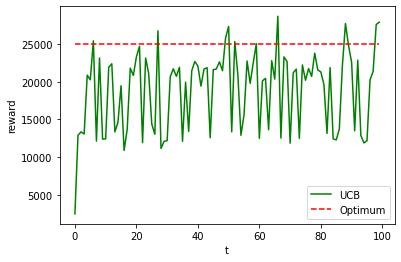

In [19]:
opt = 24995.130300000004

opt_list = np.zeros(100)
for i in range (100):
  opt_list[i] = opt

plt.plot(rewards_list, 'g')
plt.plot(opt_list, 'r--')
plt.legend(['UCB', 'Optimum'])
plt.ylabel('reward')
plt.xlabel('t')

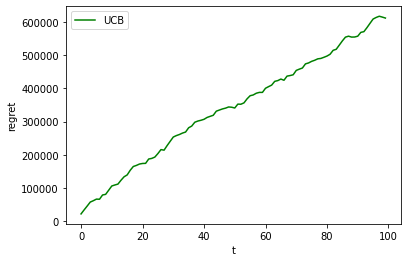

In [21]:
regrets_list = [] 
for reward in rewards_list :
    regret = opt - reward
    regrets_list.append(regret)

plt.plot(np.cumsum(regrets_list), 'g')
plt.legend(['UCB'])
plt.ylabel('regret')
plt.xlabel('t')
plt.show()